[Tutorials](https://langchain-ai.github.io/langgraph/tutorials/)

[Quick Start](https://langchain-ai.github.io/langgraph/tutorials/introduction/)

# Quick Start

In this comprehensive quick start, we will build a support chatbot in LangGraph that can:

- Answer common questions by searching the web
- Maintain conversation state across calls
- Route complex queries to a human for review
- Use custom state to control its behavior
- Rewind and explore alternative conversation paths

We'll start with a basic chatbot and progressively add more sophisticated capabilities, introducing key LangGraph concepts along the way.

## Setup

First, install the required packages:

In [5]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai

Next, set your API keys:

**rm notes**
1. `import os:` **os module**, which provides a way of using operating system-dependent functionality, such as reading or writing to environment variables.
2. `from google.colab import userdata`  the **`userdata`** module from Google Colab, which is used to manage user-specific data and secrets.
3. **Environment Variables**
* `os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')` :
This line sets an environment variable named LANGCHAIN_API_KEY with the value retrieved from Google Colab's userdata for LANGCHAIN_API_KEY.
* `os.environ["LANGCHAIN_TRACING_V2"] = "true"`:
This line sets an environment variable named LANGCHAIN_TRACING_V2 to the string "true".

* `os.environ["LANGCHAIN_PROJECT"] = "quickstart"`:
This line sets an environment variable named LANGCHAIN_PROJECT to the string "quickstart".
4. **Retrieve Gemini API Key**:
* `gemini_api_key = userdata.get('GEMINI_API_KEY')`:
This retrieves the value of GEMINI_API_KEY from Google Colab's userdata and assigns it to the variable gemini_api_key.



In [18]:
# check each set is running
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "quickstart"

gemini_api_key = userdata.get('GEMINI_API_KEY')

**rm note** ChatGoogleGenerativeAI model to generate a greeting based on the prompt

`llm`: This creates an instance of ChatGoogleGenerativeAI.

`model="gemini-1.5-flash"`: Specifies the model to use, in this case, "gemini-1.5-flash".

`max_retries=2`: Sets the number of retries in case of an error to 2.

`api_key=gemini_api_key`: Uses the API key stored in the variable gemini_api_key.

`llm.invoke("greet me")`

This calls the invoke method on the llm object, passing the string "greet me".

The model will generate a response to the prompt "greet me".

In [19]:
# check graph is running
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=gemini_api_key
)

llm.invoke("lang graph")

AIMessage(content="Please provide me with more context! I need more information to understand what you're asking for. \n\nFor example, tell me:\n\n* **What kind of graph are you interested in?**  (e.g., bar graph, line graph, pie chart, scatter plot, etc.)\n* **What data do you want to represent in the graph?** (e.g., sales figures, population growth, website traffic, etc.)\n* **What programming language or tool are you using?** (e.g., Python with matplotlib, R, Excel, Google Sheets, etc.)\n\nOnce I have this information, I can help you create a graph. \n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': '

In [20]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=gemini_api_key
)

response = llm.invoke([{"role": "user", "content": "greet me"}])

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>.
    </p>
</div>

## Part 1: Build a Basic Chatbot

We'll first create a simple chatbot using LangGraph. This chatbot will respond directly to user messages. Though simple, it will illustrate the core concepts of building with LangGraph. By the end of this section, you will have a built rudimentary chatbot.

Start by creating a `StateGraph`. A `StateGraph` object defines the structure of our chatbot as a "state machine". We'll add `nodes` to represent the llm and functions our chatbot can call and `edges` to specify how the bot should transition between these functions.

**rm notes**

**Import Statements:**

Annotated: Used to add metadata to types.

TypedDict: A way to define dictionary-like structures with typed keys and values.

StateGraph, START, END: Imported classes or constants from langgraph.graph.

add_messages: A function from langgraph.graph.message used in message handling.

**Define a TypedDict:**
```bash
class State(TypedDict):
    messages: Annotated[list, add_messages]
```
State: A dictionary-like structure with a key messages.

Annotated [list, add_messages]: Indicates that messages should be a list, and add_messages function defines how this list should be updated (appends new messages).

**Create a StateGraph:**
```bash
graph_builder = StateGraph(State)
```
graph_builder: An instance of StateGraph using the State structure.

StateGraph: A class used to create and manage a state graph.

In [7]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

**rm note**

**`add_messages` Function**

```bash
message = add_messages(new_messages_1, new_messages_2)
```
**Purpose:** The add_messages function is used to combine or append new_messages_2 to new_messages_1.

**Result:** This function call will result in message containing the combined list of messages from new_messages_1 and new_messages_2.

In [6]:
# Example usage of add_messages
new_messages_1 = [{"role": "user", "content": "Hello"}]
new_messages_2 = [{"role": "ai", "content": "Hi there!"}]

message = add_messages(new_messages_1, new_messages_2)


# # print("Updated State 1:", updated_state_1)

# from typing import Annotated
# from typing_extensions import TypedDict
# from langgraph.graph import StateGraph

# class State(TypedDict):
#     messages: Annotated[list, add_messages]

# builder = StateGraph(State)
# builder.add_node("chatbot", lambda state: {"messages": [("assistant", "Hello")]})
# builder.set_entry_point("chatbot")
# builder.set_finish_point("chatbot")
# graph = builder.compile()
# graph.invoke({"messages": [{"role": "user", "content": "Hello"}]})

<div class="admonition tip">
    <p class="admonition-title">Note</p>
    <p>
    The first thing you do when you define a graph is define the <code>State</code> of the graph. The <code>State</code> consists of the schema of the graph as well as reducer functions which specify how to apply updates to the state. In our example <code>State</code> is a <code>TypedDict</code> with a single key: <code>messages</code>. The <code>messages</code> key is annotated with the <a href="https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages"><code>add_messages</code></a> reducer function, which tells LangGraph to append new messages to the existing list, rather than overwriting it. State keys without an annotation will be overwritten by each update, storing the most recent value. Check out <a href="https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages">this conceptual guide</a> to learn more about state, reducers and other low-level concepts.
    </p>
</div>

So now our graph knows two things:

1. Every `node` we define will receive the current `State` as input and return a value that updates that state.
2. `messages` will be _appended_ to the current list, rather than directly overwritten. This is communicated via the prebuilt [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) function in the `Annotated` syntax.

Next, add a "`chatbot`" node. Nodes represent units of work. They are typically regular python functions.

**rm note**
The error occurs because you're trying to add a node to a graph that has already been compiled, and the node name chatbot is already present in the graph.

In [8]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

**Notice** how the `chatbot` node function takes the current `State` as input and returns a dictionary containing an updated `messages` list under the key "messages". This is the basic pattern for all LangGraph node functions.

The `add_messages` function in our `State` will append the llm's response messages to whatever messages are already in the state.

Next, add an `entry` point. This tells our graph **where to start its work** each time we run it.

In [9]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# Check if the node already exists before adding it
if "chatbot" not in graph_builder.nodes:
    # The first argument is the unique node name
    # The second argument is the function or object that will be called whenever
    # the node is used.
    graph_builder.add_node("chatbot", chatbot)
else:
    print("Node 'chatbot' already present.")


Node 'chatbot' already present.


In [15]:
graph_builder.add_edge(START, "chatbot")

Similarly, set a `finish` point. This instructs the graph **"any time this node is run, you can exit."**

In [14]:
graph_builder.add_edge("chatbot", END)

Finally, we'll want to be able to run our graph. To do so, call "`compile()`" on the graph builder. This creates a "`CompiledGraph`" we can use invoke on our state.

In [11]:
graph = graph_builder.compile()

You can visualize the graph using the `get_graph` method and one of the "draw" methods, like `draw_ascii` or `draw_png`. The `draw` methods each require additional dependencies.

**rm notes**

`graph.get_graph()`: This part likely retrieves the graph object you're working with. Think of it as a call to grab the current state or structure of your graph.

`draw_mermaid_png()`: This method on the graph object seems to be responsible for creating a PNG image using Mermaid syntax. Mermaid is a text-based diagramming tool, great for visualizing complex structures like databases or code flowcharts.

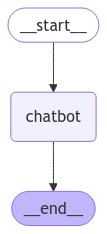

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

**rm not**

Extracts the latest message from the use

In [21]:
for event in graph.stream({"messages": [("user", "I am Raheela")]}):
    print("EVENT:", list(event.values())[0]["messages"][-1].content)

EVENT: Hello Raheela! It's nice to meet you. 

What can I do for you today?  



Now let's run the chatbot!

**Tip:** You can exit the chat loop at any time by typing "quit", "exit", or "q".

In [23]:
# rm code  :- history is not maintain in this code
# code starts a conversation loop, reading user input, and streaming graph updates accordingly

def stream_graph_updates(user_input: str):
    # Stream updates from the graph based on user input
    for event in graph.stream({"messages": [("user", user_input)]}):
        # Iterate over each event's values
        for value in event.values():
            # Print the latest assistant message content from the event
            print("Assistant:", value["messages"][-1].content)

# Main loop to keep the conversation going
while True:
    try:
        # Prompt user for input
        user_input = input("User: ")
        # Check if the user wants to quit
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        # Stream graph updates with the user's input
        stream_graph_updates(user_input)
    except:
        # Fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break


User: I am raheela
Assistant: Nice to meet you, Raheela! What can I do for you today? 

User: who I am
Assistant: As a large language model, I don't have a personal identity like you do. I am a computer program designed to process and generate text. I can access and process information from the real world through Google Search and keep my response consistent with search results. 

To understand who *you* are, I need more information!  Tell me about yourself. What are your interests? What are your goals? What makes you unique? 

I'm eager to learn more about you! 

User: karachi weather
Assistant: I do not have access to real-time information, including weather conditions. To get the current weather in Karachi, I recommend checking a reliable weather website or app. 

Here are some resources you can use:

* **AccuWeather:** [https://www.accuweather.com/](https://www.accuweather.com/)
* **The Weather Channel:** [https://weather.com/](https://weather.com/)
* **Google Weather:** [https://w

**Congratulations!** You've built your first chatbot using LangGraph. This bot can engage in basic conversation by taking user input and generating responses using an LLM. You can inspect a [LangSmith Trace](https://smith.langchain.com/public/7527e308-9502-4894-b347-f34385740d5a/r) for the call above at the provided link.

However, you may have noticed that the bot's knowledge is limited to what's in its training data. In the next part, we'll add a web search tool to expand the bot's knowledge and make it more capable.

Below is the full code for this section for your reference:

<details>
<summary>Full Code</summary>
    <pre>
        
```python
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()
```

</pre>
</details>

## Part 2: Enhancing the Chatbot with Tools

To handle queries our chatbot can't answer "from memory", we'll integrate a web search tool. Our bot can use this tool to find relevant information and provide better responses.

#### Requirements

Before we start, make sure you have the necessary packages installed and API keys set up:

First, install the requirements to use the [Tavily Search Engine](https://python.langchain.com/docs/integrations/tools/tavily_search/), and set your [TAVILY_API_KEY](https://tavily.com/).

In [26]:
%%capture --no-stderr
%pip install -U tavily-python langchain_community

In [27]:
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

**rm note**

**`ToolNode`** is a built-in function of LangGraph. We can create our own custom function that provides a list of tools such as a search engine, Excel file operations, weather search, or database search in SQL. To integrate these tools into LangGraph, pass them into a custom `ToolNode`. We’ll build our own `BasicToolNode` and replace LangGraph’s prebuilt `ToolNode` and `tools_condition` with it, using

ToolNode(tools=[your_tool]).


**ToolNode** is essentially a node within a workflow or graph that is designated to execute a specific tool or function when called.

**ToolNode** is a LangChain Runnable that takes graph state (with a list of messages) as input and outputs state update with the result of tool calls.

**ToolNode** is just a class that helps with this execution. You pass it your list of tools, and internally it stores them as name-function pairs.

**rm note**

**`add_conditional_edges()`** is a function used to add conditional connections between nodes in a graph, based on specific conditions. It helps create dynamic workflows where the next step depends on certain criteria being met.

**`graph_builder.add_conditional_edges("chatbot", tools_condition)`**

Purpose: Adds an edge from the `chatbot` node to another node, only if the `tools_condition` is satisfied.

Next, define the tool:

In [30]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': "In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed. State management. One of LangGraph's standout features is its automatic state"},
 {'url': 'https://www.gettingstarted.ai/langgraph-tutorial-with-example/',
  'content': "LangGraph is a library built by the LangChain team that aims to help developers create graph-based single or multi-agent AI applications. As a low-level framework, LangGraph lets you control how agents interact with each other, which tools to use, and how information flows within the application. LangGraph uses this graph concept to organize AI agents and their interactions. We can then build our Graph by passing our State to the StateGraph class so that all graph nodes communicate

The results are page summaries our chat bot can use to answer questions.


Next, we'll start defining our graph. The following is all **the same as in Part 1**, except we have added `bind_tools` on our LLM. This lets the LLM know the correct JSON format to use if it wants to use our search engine.

In [33]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [34]:
llm

ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), max_retries=2, client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x7fbef1044610>, default_metadata=())

In [35]:
llm_with_tools

RunnableBinding(bound=ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), max_retries=2, client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x7fbef1044610>, default_metadata=()), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search_results_json', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'search query to look up', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [36]:
llm_with_tools.invoke("lang graph scope in 2024")

AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "lang graph scope in 2024"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-3f378a50-f40f-4c3e-9eff-27f2c9def2b9-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'lang graph scope in 2024'}, 'id': '4f9855de-554b-41b6-bf01-23d806b71580', 'type': 'tool_call'}], usage_metadata={'input_tokens': 83, 'output_tokens': 28, 'total_tokens': 111, 'input_token_details': {'cache_read': 0}})

Next we need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node.

Below, we implement a `BasicToolNode` that checks the most recent message in the state and calls tools if the message contains `tool_calls`. It relies on the LLM's `tool_calling` support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

We will later replace this with LangGraph's prebuilt [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode) to speed things up, but building it ourselves first is instructive.

**rm notes**

`tool_call` allows the system to perform specific tasks or fetch data via defined tools. It encapsulates everything needed to execute the tool and retrieve results.

In [37]:
tool_calls=[
    {'name': 'tavily_search_results_json',
     'args': {'query': 'lang graph scope in 2024'},
     'id': 'bf5b687b-b665-4949-92f5-ac1ea90ed1a9',
     'type': 'tool_call'}]

In [38]:
tools_by_name = {tool.name: tool for tool in tools}
print("tools_by_name type ", type(tools_by_name))
print("tools_by_name ",tools_by_name)



tools_by_name type  <class 'dict'>
tools_by_name  {'tavily_search_results_json': TavilySearchResults(max_results=2, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))}


In [39]:
print(" pass key \t")
tools_by_name["tavily_search_results_json"]

 pass key 	


TavilySearchResults(max_results=2, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))

In [40]:
print("call llm_with_tools.invoke \t")
llm_with_tools.invoke("search using tool and what polls say about winner 2024 presidential elections")

call llm_with_tools.invoke 	


AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "polls about 2024 presidential election"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-855ddd2c-e813-4b71-9961-1cc995b17af9-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'polls about 2024 presidential election'}, 'id': 'c3452e16-a3ea-4dd2-b71f-63ce18501048', 'type': 'tool_call'}], usage_metadata={'input_tokens': 90, 'output_tokens': 28, 'total_tokens': 118, 'input_token_details': {'ca

 [PIAIC GenAI Classes - Nov 1, 2024 ](https://www.youtube.com/watch?v=eZ2yFnGi9hE&t=800s)  
 time 1:18

In [41]:
# BasicToolNode class is designed to execute tools requested by an AI message

import json

from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        # Initialize the node with the provided tools
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        # State Key = messages
        if messages := inputs.get("messages", []):
            # Last Message == AI Message
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        # Initialize the list for the tool's outputs
        outputs = []
        for tool_call in message.tool_calls:
            # Invoke the tool with the provided arguments
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            # Create a ToolMessage with the result and append it to the outputs list
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        # Return the outputs as messages
        return {"messages": outputs}

# Initialize the BasicToolNode with the provided tools
tool_node = BasicToolNode(tools=[tool])
# Add the tool_node to the graph_builder with the node name "tools"
graph_builder.add_node("tools", tool_node)


**rm note**

**Initialization:**

The `__init__` method takes a list of tools and stores them in a dictionary `tools_by_name` where each tool's name is the key.

**Execution:**

The `__call__` method is triggered with a dictionary of inputs.

It looks for "messages" in the inputs and takes the last one (the most recent AI message).

If no message is found, it raises an error.

For each tool call in the message, it invokes the corresponding tool using the stored dictionary.

It captures the tool's result, formats it as a `ToolMessage`, and collects these in the `outputs` list.

Finally, it returns the outputs as "messages".

**AI interactions, these three message types form the backbone of communication**

HumanMessage, ToolMessage, SystemMessage

In [42]:
## sets up an AIMessage with a tool call, passes it to a tool_node, and processes it based on the defined tool interactions

from langchain_core.messages import HumanMessage, AIMessage

# Create a list of messages with an AIMessage
messages = [
AIMessage(content='',
          additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "2024 presidential elections polls"}'}},
          response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []},
          id='run-621e608b-24ae-4d50-8605-33415037f7df-0',
          tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '2024 presidential elections polls'}, 'id': '826c7148-a96a-4f79-9c64-325c97489d5e', 'type': 'tool_call'}],
          usage_metadata={'input_tokens': 90, 'output_tokens': 16, 'total_tokens': 106, 'input_token_details': {'cache_read': 0}})
]

# Pass the messages to the tool_node instance
tool_node(inputs={"messages": messages})

{'messages': [ToolMessage(content='[{"url": "https://projects.fivethirtyeight.com/2024-election-forecast/", "content": "With the 2024 presidential election a week away, 538\'s Galen Druke and G. Elliott Morris discuss the relevancy of early voting data. October 29, 2024. The 2024 election could hinge on Pennsylvania. ... What the polls say about the 2024 election."}, {"url": "https://today.yougov.com/elections/us/2024", "content": "Explore YouGov\'s freely accessible data Discover our public data, featuring a diverse range of survey results, articles, trackers and popularity rankings. Get intelligence from our ever-growing source of consumer data on 27 million+ registered panel members in 55+ markets. Public Data Explore YouGov\'s freely accessible dataFor Business Helping the world\'s most recognised brands, media owners and agencies2024 Election Discover Key Insights on the U.S. Presidential Election 2024Sign in Sign up Explore YouGov\'s freely accessible data Discover our public dat

With the tool node added, we can define the `conditional_edges`.

Recall that **edges** route the control flow from one node to the next. **Conditional edges** usually contain "if" statements to route to different nodes depending on the current graph state. These functions receive the current graph `state` and return a string or list of strings indicating which node(s) to call next.

Below, call define a router function called `route_tools`, that checks for tool_calls in the chatbot's output. Provide this function to the graph by calling `add_conditional_edges`, which tells the graph that whenever the `chatbot` node completes to check this function to see where to go next.

The condition will route to `tools` if tool calls are present and `END` if not.

Later, we will replace this with the prebuilt [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition) to be more concise, but implementing it ourselves first makes things more clear.

In [43]:
from typing import Literal


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

**Notice** that conditional edges start from a single node. This tells the graph "any time the '`chatbot`' node runs, either go to 'tools' if it calls a tool, or end the loop if it responds directly.

Like the prebuilt `tools_condition`, our function returns the `END` string if no tool calls are made. When the graph transitions to `END`, it has no more tasks to complete and ceases execution. Because the condition can return `END`, we don't need to explicitly set a `finish_point` this time. Our graph already has a way to finish!

Let's visualize the graph we've built. The following function has some additional dependencies to run that are unimportant for this tutorial.

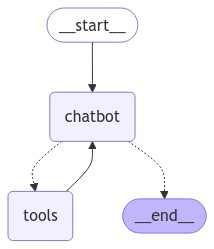

In [44]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now we can ask the bot questions outside its training data.

In [ ]:
# 1) Web search is available. 2) Does not maintain chat history (no memory).
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: hello
Assistant: Hello! 👋 How can I help you today? 😊 

User: karachi weather
Assistant: 
Assistant: [{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Karachi', 'region': 'Sindh', 'country': 'Pakistan', 'lat': 24.8667, 'lon': 67.05, 'tz_id': 'Asia/Karachi', 'localtime_epoch': 1730824083, 'localtime': '2024-11-05 21:28'}, 'current': {'last_updated_epoch': 1730823300, 'last_updated': '2024-11-05 21:15', 'temp_c': 27.3, 'temp_f': 81.1, 'is_day': 0, 'condition': {'text': 'Clear', 'icon': '//cdn.weatherapi.com/weather/64x64/night/113.png', 'code': 1000}, 'wind_mph': 8.3, 'wind_kph': 13.3, 'wind_degree': 275, 'wind_dir': 'W', 'pressure_mb': 1015.0, 'pressure_in': 29.97, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 54, 'cloud': 0, 'feelslike_c': 29.1, 'feelslike_f': 84.4, 'windchill_c': 27.3, 'windchill_f': 81.2, 'heatindex_c': 29.2, 'heatindex_f': 84.5, 'dewpoint_c': 19.9, 'dewpoint_f': 67.8, 'vis_km': 6.0, 'vis_miles': 3.0, 'uv': 0.0, 'gust_mph': 12.2, 'gus

**Congrats!** You've created a conversational agent in langgraph that can use a search engine to retrieve updated information when needed. Now it can handle a wider range of user queries. To inspect all the steps your agent just took, check out this [LangSmith trace](https://smith.langchain.com/public/4fbd7636-25af-4638-9587-5a02fdbb0172/r).

Our chatbot still can't remember past interactions on its own, limiting its ability to have coherent, multi-turn conversations. In the next part, we'll add **memory** to address this.


The full code for the graph we've created in this section is reproduced below, replacing our `BasicToolNode` for the prebuilt [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode), and our `route_tools` condition with the prebuilt [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition)

<details>
<summary>Full Code</summary>
    <pre>

```python
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()
```

</pre>
</details>

## Part 3: Adding Memory to the Chatbot

Our chatbot can now use tools to answer user questions, but it doesn't remember the context of previous interactions. This limits its ability to have coherent, multi-turn conversations.

LangGraph solves this problem through **persistent checkpointing**. If you provide a `checkpointer` when compiling the graph and a `thread_id` when calling your graph, LangGraph automatically saves the state after each step. When you invoke the graph again using the same `thread_id`, the graph loads its saved state, allowing the chatbot to pick up where it left off.

We will see later that **checkpointing** is _much_ more powerful than simple chat memory - it lets you save and resume complex state at any time for error recovery, human-in-the-loop workflows, time travel interactions, and more. But before we get too ahead of ourselves, let's add checkpointing to enable multi-turn conversations.

To get started, create a `MemorySaver` checkpointer.

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

**Notice** we're using an in-memory checkpointer. This is convenient for our tutorial (it saves it all in-memory). In a production application, you would likely change this to use `SqliteSaver` or `PostgresSaver` and connect to your own DB.

Next define the graph. Now that you've already built your own `BasicToolNode`, we'll replace it with LangGraph's prebuilt `ToolNode` and `tools_condition`, since these do some nice things like parallel API execution. Apart from that, the following is all copied from Part 2.

**rm note**

**`MemorySaver()`** : it saves it all in-memory


[PIAIC GenAI Classes - Nov 1, 2024](https://www.youtube.com/watch?v=eZ2yFnGi9hE&t=800s). TooNode time 1:44

In [45]:
# This code sets up a graph-based workflow for a chatbot, integrating a
# search tool to handle user queries and manage responses dynamically

from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

# Define the State type with a list of messages
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Initialize the graph builder with the State type
graph_builder = StateGraph(State)

# Initialize the TavilySearchResults tool with a maximum of 2 results
tool = TavilySearchResults(max_results=2)
tools = [tool]

# Bind the tools to the language model
llm_with_tools = llm.bind_tools(tools)

# Define the chatbot function that processes the state and invokes the language model
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Add the chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)

# Initialize the ToolNode with the provided tools
tool_node = ToolNode(tools=[tool])
# Add the tool_node to the graph with the node name "tools"
graph_builder.add_node("tools", tool_node)

# Add conditional edges to the graph: from chatbot to tools if tools_condition is met
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# Any time a tool is called, return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
# Start the graph with the chatbot node
graph_builder.add_edge(START, "chatbot")

# Graph construction complete, ready to compile and execute


In [46]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

Finally, compile the graph with the provided checkpointer.

In [ ]:
graph = graph_builder.compile(checkpointer=memory)

Notice the connectivity of the graph hasn't changed since Part 2. All we are doing is checkpointing the `State` as the graph works through each node.

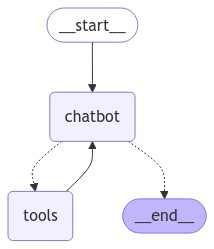

In [47]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now you can interact with your bot! First, pick a thread to use as the key for this conversation.

In [ ]:
config = {"configurable": {"thread_id": "1"}}

Next, call your chat bot.

In [ ]:
user_input = "Hi there! My name is Raheela."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Raheela.
================================== Ai Message ==================================

Nice to meet you, Raheela! 👋  What can I do for you today?


**Note:** The config was provided as the **second positional argument** when calling our graph. It importantly is _not_ nested within the graph inputs (`{'messages': []}`).

Let's ask a followup: see if it remembers your name.

In [ ]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I will try my best to remember your name, Raheela! 😊  Is there anything else I can help you with?


**Notice** that we aren't using an external list for memory: it's all handled by the checkpointer! You can inspect the full execution in this [LangSmith trace](https://smith.langchain.com/public/29ba22b5-6d40-4fbe-8d27-b369e3329c84/r) to see what's going on.

Don't believe me? Try this using a different config.

In [ ]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I am sorry, I do not have memory of past conversations. I am a large language model, and I am not able to retain information from previous interactions.


**Notice** that the **only** change we've made is to modify the `thread_id` in the config. See this call's [LangSmith trace](https://smith.langchain.com/public/51a62351-2f0a-4058-91cc-9996c5561428/r) for comparison.

By now, we have made a few checkpoints across two different threads. But what goes into a checkpoint? To inspect a graph's `state` for a given config at any time, call `get_state(config)`.

In [ ]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Raheela.', additional_kwargs={}, response_metadata={}, id='fc2ca47e-6c55-4199-933e-f8fa22fe1257'), AIMessage(content='Nice to meet you, Raheela! 👋  What can I do for you today? \n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-83237939-0e9c-4270-852e-bddcc48408f6-0', usage_metadata={'input_tokens': 84, 'output_tokens': 19, 'total_tokens': 103, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='Remember my name?', additio

In [ ]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()

**rm notes**
### Integrating memory checkpointing

**`graph = graph_builder.compile(checkpointer=MemorySaver()) `** compiles the graph with memory checkpointing, allowing it to save and restore the state of the graph's nodes during its execution.


 **This code is to create a chatbot using the LangChain framework, integrating tools for search results and memory checkpointing**

In [ ]:
# this code is to create a chatbot using the LangChain framework,
# integrating tools for search results and memory checkpointing

from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver  # Import memory checkpointing
from langgraph.graph import StateGraph  # Import StateGraph to build the graph
from langgraph.graph.message import add_messages  # Import add_messages function
from langgraph.prebuilt import ToolNode  # Import ToolNode

# Define State with messages
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Initialize the StateGraph with State
graph_builder = StateGraph(State)

# Initialize the search tool and list of tools
tool = TavilySearchResults(max_results=2)
tools = [tool]

# Initialize the language model and bind it with tools

llm_with_tools = llm.bind_tools(tools)

# Define the chatbot function to invoke the language model
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Add the chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)

# Add the tools node to the graph
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# Add conditional edges between nodes
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# Add an edge from the tools node to the chatbot node
graph_builder.add_edge("tools", "chatbot")

# Set the chatbot as the entry point of the graph
graph_builder.set_entry_point("chatbot")

# Compile the graph with memory checkpointing
graph = graph_builder.compile(checkpointer=MemorySaver())


The snapshot above contains the current state values, corresponding config, and the `next` node to process. In our case, the graph has reached an `END` state, so `next` is empty.

**Congratulations!** Your chatbot can now maintain conversation state across sessions thanks to LangGraph's checkpointing system. This opens up exciting possibilities for more natural, contextual interactions. LangGraph's checkpointing even handles **arbitrarily complex graph states**, which is much more expressive and powerful than simple chat memory.

In the next part, we'll introduce human oversight to our bot to handle situations where it may need guidance or verification before proceeding.
  
Check out the code snippet below to review our graph from this section.

**This code is to create a chatbot using the LangChain framework, integrating tools for search results and memory checkpointing**

<details>
<summary>Full Code</summary>
    <pre>

```python

from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver  # Import memory checkpointing
from langgraph.graph import StateGraph  # Import StateGraph to build the graph
from langgraph.graph.message import add_messages  # Import add_messages function
from langgraph.prebuilt import ToolNode  # Import ToolNode

# Define State with messages
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Initialize the StateGraph with State
graph_builder = StateGraph(State)

# Initialize the search tool and list of tools
tool = TavilySearchResults(max_results=2)
tools = [tool]

# Initialize the language model and bind it with tools
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)

# Define the chatbot function to invoke the language model
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Add the chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)

# Add the tools node to the graph
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# Add conditional edges between nodes
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# Add an edge from the tools node to the chatbot node
graph_builder.add_edge("tools", "chatbot")

# Set the chatbot as the entry point of the graph
graph_builder.set_entry_point("chatbot")

# Compile the graph with memory checkpointing
graph = graph_builder.compile(checkpointer=MemorySaver())

```
</pre>
</pre>
</details>

## Part 4: Human-in-the-loop

Agents can be unreliable and may need human input to successfully accomplish tasks. Similarly, for some actions, you may want to require human approval before running to ensure that everything is running as intended.

LangGraph supports `human-in-the-loop` workflows in a number of ways. In this section, we will use LangGraph's `interrupt_before` functionality to always break the tool node.

First, start from our existing code. The following is copied from Part 3.

In [ ]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

memory = MemorySaver()


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

Now, compile the graph, specifying to `interrupt_before` the `tools` node.

In [ ]:
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ tools, if desired.
    # interrupt_after=["tools"]
)

In [ ]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (e18e6327-dfad-4d27-a806-b746960bf921)
 Call ID: e18e6327-dfad-4d27-a806-b746960bf921
  Args:
    query: LangGraph


Let's inspect the graph state to confirm it worked.

In [ ]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

**Notice** that unlike last time, the "next" node is set to **'tools'**. We've interrupted here! Let's check the tool invocation.

In [ ]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph'},
  'id': 'e18e6327-dfad-4d27-a806-b746960bf921',
  'type': 'tool_call'}]

This query seems reasonable. Nothing to filter here. The simplest thing the human can do is just let the graph continue executing. Let's do that below.

Next, continue the graph! Passing in `None` will just let the graph continue where it left off, without adding anything new to the state.

In [ ]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (e18e6327-dfad-4d27-a806-b746960bf921)
 Call ID: e18e6327-dfad-4d27-a806-b746960bf921
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "LangGraph is a library within the LangChain ecosystem that simplifies the development of complex, multi-agent large language model (LLM) applications. Learn how to use LangGraph to create stateful, flexible, and scalable systems with nodes, edges, and state management."}, {"url": "https://langchain-ai.github.io/langgraph/", "content": "LangGraph is a low-level framework that allows you to create stateful, multi-actor applications with LLMs, using cycles, controllability, and persistence. Learn how to use LangGraph with LangChain, LangSmith, and Anthropic tools to b

Review this call's [LangSmith trace](https://smith.langchain.com/public/4d7f8757-9d3b-43b9-88b6-aeab0595bc4c/r) to see the exact work that was done in the above call. Notice that the state is loaded in the first step so that your chatbot can continue where it left off.

**Congrats!** You've used an `interrupt` to add human-in-the-loop execution to your chatbot, allowing for human oversight and intervention when needed. This opens up the potential UIs you can create with your AI systems. Since we have already added a **checkpointer**, the graph can be paused **indefinitely** and resumed at any time as if nothing had happened.

Next, we'll explore how to further customize the bot's behavior using custom state updates.

Below is a copy of the code you used in this section. The only difference between this and the previous parts is the addition of the `interrupt_before` argument.

<details>
<summary>Full Code</summary>
    <pre>

```python
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ actions, if desired.
    # interrupt_after=["tools"]
)
```
</pre>
</details>

## Part 5: Manually Updating the State

In the previous section, we showed how to interrupt a graph so that a human could inspect its actions. This lets the human `read` the state, but if they want to change their agent's course, they'll need to have `write` access.

Thankfully, LangGraph lets you **manually update state**! Updating the state lets you control the agent's trajectory by modifying its actions (even modifying the past!). This capability is particularly useful when you want to correct the agent's mistakes, explore alternative paths, or guide the agent towards a specific goal.

We'll show how to update a checkpointed state below. As before, first, define your graph. We'll reuse the exact same graph as before.

[PIAIC GenAI Classes - Nov 2, 2024](https://www.youtube.com/watch?v=UhfcycocwkU&t=138s)

time 41

In [ ]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt **after** actions, if desired.
    # interrupt_after=["tools"]
)


In [ ]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "4"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [ ]:
snapshot = graph.get_state(config) # get currentstatus
print(snapshot)

StateSnapshot(values={'messages': [HumanMessage(content="I'm learning LangGraph. Could you do some research on it for me?", additional_kwargs={}, response_metadata={}, id='d6291abf-11e9-439f-a944-e63810cc01f7'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "LangGraph"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-33a89a6d-f644-4bfb-8f81-3a7b6f971e5c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': '8b4d9a3a-1974

In [ ]:
snapshot    # print status

StateSnapshot(values={'messages': [HumanMessage(content="I'm learning LangGraph. Could you do some research on it for me?", additional_kwargs={}, response_metadata={}, id='d6291abf-11e9-439f-a944-e63810cc01f7'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "LangGraph"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-33a89a6d-f644-4bfb-8f81-3a7b6f971e5c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': '8b4d9a3a-1974

In [ ]:
#snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]    # get last message
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (8b4d9a3a-1974-4ce7-8970-b9f6b8643cb9)
 Call ID: 8b4d9a3a-1974-4ce7-8970-b9f6b8643cb9
  Args:
    query: LangGraph


**rm code**

llm only indicates which tool we should use.

In [ ]:
# tool message
from langchain_core.messages import AIMessage, ToolMessage

who_pass_message = ToolMessage(content='Hi I am tool Response', tool_call_id='007')
print(who_pass_message)

content='Hi I am tool Response' tool_call_id='007'


So far, all of this is an _exact repeat_ of the previous section. The LLM just requested to use the search engine tool and our graph was interrupted. If we proceed as before, the tool will be called to search the web.

But what if the user wants to intercede? What if we think the chat bot doesn't need to use the tool?

Let's directly provide the correct response!

In [ ]:
from langchain_core.messages import AIMessage, ToolMessage

tavily_answer = (
    "LangGraph is a library for building stateful, multi-actor applications with LLMs."
)
new_messages = [
    # The LLM API expects some ToolMessage to match its tool call. We'll satisfy that here.
    ToolMessage(content=tavily_answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    # And then directly "put words in the LLM's mouth" by populating its response.
    AIMessage(content=tavily_answer),
]

new_messages[-1].pretty_print()
graph.update_state(
    # Which state to update
    config,
    # The updated values to provide. The messages in our `State` are "append-only", meaning this will be appended
    # to the existing state. We will review how to update existing messages in the next section!
    {"messages": new_messages},
)

print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])

================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


Last 2 messages;
[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='266cf043-1620-4113-adfe-13312f12bc7c', tool_call_id='8b4d9a3a-1974-4ce7-8970-b9f6b8643cb9'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', additional_kwargs={}, response_metadata={}, id='e60b3ffa-f4b6-49ac-91a2-82a8a1d58d8b')]


In [ ]:
for m in new_messages:
  m.pretty_print()

================================= Tool Message =================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.
================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


Now the graph is complete, since we've provided the final response message! Since state updates simulate a graph step, they even generate corresponding traces. Inspec the [LangSmith trace](https://smith.langchain.com/public/6d72aeb5-3bca-4090-8684-a11d5a36b10c/r) of the `update_state` call above to see what's going on.

**Notice** that our new messages are _appended_ to the messages already in the state. Remember how we defined the `State` type?

```python
class State(TypedDict):
    messages: Annotated[list, add_messages]
```

We annotated `messages` with the pre-built `add_messages` function. This instructs the graph to always append values to the existing list, rather than overwriting the list directly. The same logic is applied here, so the messages we passed to `update_state` were appended in the same way!

The `update_state` function operates as if it were one of the nodes in your graph! By default, the update operation uses the node that was last executed, but you can manually specify it below. Let's add an update and tell the graph to treat it as if it came from the "chatbot".

In [ ]:
graph.update_state(
    config,
    {"messages": [AIMessage(content="I'm an AI expert!")]},
    # Which node for this function to act as. It will automatically continue
    # processing as if this node just ran.
     as_node="chatbot",
)

{'configurable': {'thread_id': '4',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef9c324-aa8c-6a45-8003-64daa8ea45b3'}}

In [ ]:
print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2])



Last 2 messages;
content='LangGraph is a library for building stateful, multi-actor applications with LLMs.' additional_kwargs={} response_metadata={} id='e60b3ffa-f4b6-49ac-91a2-82a8a1d58d8b'


In [ ]:
# give all the messages, before graph run (human & AI message) and after message Too message
# update_state()
for m in graph.get_state(config).values['messages']:
  m.pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (8b4d9a3a-1974-4ce7-8970-b9f6b8643cb9)
 Call ID: 8b4d9a3a-1974-4ce7-8970-b9f6b8643cb9
  Args:
    query: LangGraph
================================= Tool Message =================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.
================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.
================================== Ai Message ==================================

I'm an AI expert!


[PIAIC GenAI Classes - Nov 2, 2024](https://www.youtube.com/watch?v=UhfcycocwkU&t=138s)

time 1:03

In [ ]:
# update the message , query: LangGraph
graph.update_state(
    config,
    {"messages": [AIMessage(content="I'm an AI expert!")]},
    # Which node for this function to act as. It will automatically continue
    # processing as if this node just ran.
     as_node="chatbot",
)

{'configurable': {'thread_id': '4',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef9c325-0a6d-6a08-8004-cbff63b43a6c'}}

In [ ]:
# update_state()
for m in graph.get_state(config).values['messages']:
  m.pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (8b4d9a3a-1974-4ce7-8970-b9f6b8643cb9)
 Call ID: 8b4d9a3a-1974-4ce7-8970-b9f6b8643cb9
  Args:
    query: LangGraph
================================= Tool Message =================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.
================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.
================================== Ai Message ==================================

I'm an AI expert!
================================== Ai Message ==================================

I'm an AI expert!


In [ ]:
#add_message
# 1. Add 2 List ==
# 2. Delete
# 3. Update Message in List

#add_messsages

from langchain_core.messages import HumanMessage
# Both IDs are 1, which replaces the user goal with the updated goal
# 3. Update Message in List
user_goale = HumanMessage(id=1, content='Making a Million USD using AI Agent')
update_goale = HumanMessage(id=1, content='Using Vertical LLM concept making a Million USD using AI Agent')

In [ ]:
final_goale = add_messages(user_goale, update_goale)
print(final_goale)

[HumanMessage(content='Using Vertical LLM concept making a Million USD using AI Agent', additional_kwargs={}, response_metadata={}, id='1')]


In [ ]:
from langchain_core.messages import HumanMessage

# 3. Update Message in List
user_goale = HumanMessage(id=1, content='Making a Million USD using AI Agent')
update_goale = HumanMessage(id=2, content='Using Vertical LLM concept making a Million USD using AI Agent')

In [ ]:
final_goale = add_messages(user_goale, update_goale)
print(final_goale)

[HumanMessage(content='Making a Million USD using AI Agent', additional_kwargs={}, response_metadata={}, id='1'), HumanMessage(content='Using Vertical LLM concept making a Million USD using AI Agent', additional_kwargs={}, response_metadata={}, id='2')]


In [ ]:
# reducer function (time 1:28)  DO IT LATER

# from langchain_core.messages import HumanMessage

# user_goal = AIMessage(content='Making a Million USD using AI Agent', id='1'),AIMessage(content='I am Raheela', id='2')
# update_goal = AIMessage(content='Updated Goal Content', id='1')

# final_goals_update = add_messages(user_goal, update_goal)
# print(final_goals_update)

# from langchain_core.messages import AIMessage, add_messages

# # Instantiate AIMessage objects with a valid message type
# user_goal = (
#     AIMessage(content='Making a Million USD using AI Agent', id='1', message_type='user'),
#     AIMessage(content='I am Raheela', id='2', message_type='user')
# )

# update_goal = AIMessage(content='Updated Goal Content', id='1', message_type='ai')

# # Call add_messages function with corrected messages
# final_goals_update = add_messages(user_goal, update_goal)
# print(final_goals_update)

# from langchain_core.messages import AIMessage
# from langchain_core.some_other_module import add_messages  # Replace `some_other_module` with the actual module name

# Instantiate AIMessage objects with a valid message type
# user_goal = (
#     AIMessage(content='Making a Million USD using AI Agent', id='1', message_type='user'),
#     AIMessage(content='I am Raheela', id='2', message_type='user')
# )

# update_goal = AIMessage(content='Updated Goal Content', id='1', message_type='ai')

# # Call add_messages function with corrected messages
# final_goals_update = add_messages(user_goal, update_goal)
# print(final_goals_update)




reducer function (time 1:28)  DO IT LATER

Reducer == For Manging a Key in State

Checkpointer = Persistence (checkpointer is database)

A reducer is for managing a key in state. A checkpointer is for persistence, typically using a database. The reducer function keeps the history of one flow; for example, it calculates the sum, provides the answer, and then it finishes


[PIAIC GenAI Classes - Nov 2, 2024](https://www.youtube.com/watch?v=UhfcycocwkU&t=138s)

time 1:07

In [ ]:
# rm work started check
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "20"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [ ]:
from langchain_core.messages import AIMessage

# get state
snapshot = graph.get_state(config)

In [ ]:

existing_message = snapshot.values["messages"][-1]  # Get the last message
print("Original")
print(existing_message.pretty_print())
print("Message ID", existing_message.id)
print("Tool Call [0]", existing_message.tool_calls[0])  # Assuming 'tool_calls' is a list of tool calls


Original
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (07812803-8610-43b1-aa5d-b0ba6f367293)
 Call ID: 07812803-8610-43b1-aa5d-b0ba6f367293
  Args:
    query: LangGraph
None
Message ID run-c59d93de-db63-4037-9aa4-daa4c52c067f-0
Tool Call [0] {'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': '07812803-8610-43b1-aa5d-b0ba6f367293', 'type': 'tool_call'}


In [ ]:
# Copy the first tool call from the existing message
new_tool_call = existing_message.tool_calls[0].copy()

# Update the query argument in the tool call
new_tool_call["args"]["query"] = "LangGraph Human-in-the-loop workflow"

# Create a new AIMessage with the updated tool call and same content
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state
    id=existing_message.id
)


In [ ]:
new_message.pretty_print()  # both id are same , too-id , and message-id

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (07812803-8610-43b1-aa5d-b0ba6f367293)
 Call ID: 07812803-8610-43b1-aa5d-b0ba6f367293
  Args:
    query: LangGraph Human-in-the-loop workflow


In [ ]:
print("Updated")
print(new_message.tool_calls[0])
print("Message ID", new_message.id)

Updated
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph Human-in-the-loop workflow'}, 'id': '07812803-8610-43b1-aa5d-b0ba6f367293', 'type': 'tool_call'}
Message ID run-c59d93de-db63-4037-9aa4-daa4c52c067f-0


In [ ]:
# rm work
graph.update_state(config, {"messages": [new_message]})

print("\n\nTool Calls")
print(graph.get_state(config).values["messages"][-1].tool_calls)



Tool Calls
[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph Human-in-the-loop workflow'}, 'id': '07812803-8610-43b1-aa5d-b0ba6f367293', 'type': 'tool_call'}]


In [ ]:
for m in graph.get_state(config).values["messages"]:
  m.pretty_print()  # ai message is changed but human message is same

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (07812803-8610-43b1-aa5d-b0ba6f367293)
 Call ID: 07812803-8610-43b1-aa5d-b0ba6f367293
  Args:
    query: LangGraph Human-in-the-loop workflow


[PIAIC GenAI Classes - Nov 2, 2024](https://www.youtube.com/watch?v=UhfcycocwkU&t=138s)

time 1:13

In [ ]:
# rm work ended
#  unfreeze graph and then run the graph check
# events = graph.stream(None, config, stream_mode="values")
# for event in events:
#   if "messages" in events:
#     event ["messages"][-1].pretty_print()

# events = graph.stream(None, config, stream_mode="values")
# for event in events:
#     if "messages" in event:
#         event["messages"][-1].pretty_print()

# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (07812803-8610-43b1-aa5d-b0ba6f367293)
 Call ID: 07812803-8610-43b1-aa5d-b0ba6f367293
  Args:
    query: LangGraph Human-in-the-loop workflow
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://techcommunity.microsoft.com/blog/educatordeveloperblog/an-absolute-beginners-guide-to-langgraph-js/4212496", "content": "Controllability: Being low-level, LangGraph gives high control over the workflow, which is invaluable for getting reliable outputs from non-deterministic models. Human-in-the-Loop: with a built-in persistence layer, LangGraph is designed for 'human-in-the-loop' workflows as a first-class concept."}, {"url": "https://www.youtube.com/watch?v=9BPCV5TYPmg", "content": "In this video, I'll show you how to handle persistence with LangGraph, enabling a unique Human-in-the-Loop workflo

In [ ]:
print(events)

<generator object Pregel.stream at 0x7b01891d3060>


Check out the [LangSmith trace](https://smith.langchain.com/public/2e4d92ca-c17c-49e0-92e5-3962390ded30/r) for this update call at the provided link. **Notice** from the trace that the graph continues into the `tools_condition` edge. We just told the graph to treat the update `as_node="chatbot"`. If we follow the diagram below and start from the `chatbot` node, we naturally end up in the `tools_condition` edge and then `__end__` since our updated message lacks tool calls.

In [ ]:
# check the above work

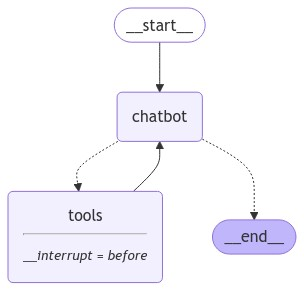

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Inspect the current state as before to confirm the checkpoint reflects our manual updates.

In [ ]:
snapshot = graph.get_state(config)
print(snapshot.values["messages"][-3:])
print(snapshot.next)

[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='0d2d3897-a968-4aa5-b739-d7f79593a443', tool_call_id='6a3adc86-5cb4-45c8-9b70-0ded6b9ef6a2'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', additional_kwargs={}, response_metadata={}, id='f7a65d05-91cc-4502-9bb7-042063ef8a5c'), AIMessage(content="I'm an AI expert!", additional_kwargs={}, response_metadata={}, id='fba74b9e-fde3-43fa-8c40-6f34cf26abdf')]
()


**Notice**: that we've continued to add AI messages to the state. Since we are acting as the `chatbot` and responding with an AIMessage that doesn't contain `tool_calls`, the graph knows that it has entered a finished state (`next` is empty).

#### What if you want to **overwrite** existing messages?

The [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) function we used to annotate our graph's `State` above controls how updates are made to the `messages` key. This function looks at any message IDs in the new `messages` list. If the ID matches a message in the existing state, [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) overwrites the existing message with the new content.

As an example, let's update the tool invocation to make sure we get good results from our search engine! First, start a new thread:

[PIAIC GenAI Classes - Nov 2, 2024](https://www.youtube.com/watch?v=UhfcycocwkU&t=138s)

time 1:07

In [ ]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "2"}}  # we'll use thread_id = 2 here
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (17e0d390-00dd-4564-ab36-5851c180c96d)
 Call ID: 17e0d390-00dd-4564-ab36-5851c180c96d
  Args:
    query: LangGraph


**Next,** let's update the tool invocation for our agent. Maybe we want to search for human-in-the-loop workflows in particular.

In [ ]:
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
print("Original")
print("Message ID", existing_message.id)
print(existing_message.tool_calls[0])

new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "LangGraph human-in-the-loop workflow"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state rather than APPEND this messages
    id=existing_message.id,
)

print("Updated")
print(new_message.tool_calls[0])
print("Message ID", new_message.id)

graph.update_state(config, {"messages": [new_message]})

print("\n\nTool calls")
graph.get_state(config).values["messages"][-1].tool_calls

Original
Message ID run-f5b00f8a-1159-42f8-9864-1346be3721cc-0
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': '17e0d390-00dd-4564-ab36-5851c180c96d', 'type': 'tool_call'}
Updated
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph human-in-the-loop workflow'}, 'id': '17e0d390-00dd-4564-ab36-5851c180c96d', 'type': 'tool_call'}
Message ID run-f5b00f8a-1159-42f8-9864-1346be3721cc-0


Tool calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph human-in-the-loop workflow'},
  'id': '17e0d390-00dd-4564-ab36-5851c180c96d',
  'type': 'tool_call'}]

**Notice** that we've modified the AI's tool invocation to search for "LangGraph human-in-the-loop workflow" instead of the simple "LangGraph".

Check out the [LangSmith trace](https://smith.langchain.com/public/cd7c09a6-758d-41d4-8de1-64ab838b2338/r) to see the state update call - you can see our new message has successfully updated the previous AI message.

Resume the graph by streaming with an input of `None` and the existing config.

PIAIC GenAI Classes - Nov 2, 2024

time 1:13

In [ ]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (17e0d390-00dd-4564-ab36-5851c180c96d)
 Call ID: 17e0d390-00dd-4564-ab36-5851c180c96d
  Args:
    query: LangGraph human-in-the-loop workflow
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.js-craft.io/blog/human-loop-langgraph-javascript/", "content": "Human-in-the-Loop in LangGraph (JavaScript version) When discussing AI agents, one concept we can't overlook is Human-in-the-Loop (HITL). Human-in-the-Loop refers to the active involvement of humans in the decision-making processes of AI agents. There are several ways to integrate humans into the AI loop. One common method is authorization, where the AI agent requires human approval for specific actions before proceeding. Another key interaction type is continuous feedback loops, where humans provide guidance throughout the AI’s 

Check out the [trace](https://smith.langchain.com/public/2d633326-14ad-4248-a391-2757d01851c4/r/6464f2f2-edb4-4ef3-8f48-ee4e249f2ad0) to see the tool call and later LLM response. **Notice** that now the graph queries the search engine using our updated query term - we were able to manually override the LLM's search here!

All of this is reflected in the graph's checkpointed memory, meaning if we continue the conversation, it will recall all the _modified_ state.

[PIAIC GenAI Classes - Nov 2, 2024](https://www.youtube.com/watch?v=UhfcycocwkU&t=138s)

time 1:15

In [ ]:
# remember old things as well
events = graph.stream(
    {
        "messages": (
            "user",
            "Remember what I'm learning about?",
        )
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember what I'm learning about?
================================== Ai Message ==================================

You are learning about LangGraph, a framework for building AI agents that can interact with the world. It is based on the idea of using a graph to represent the knowledge and goals of the agent.


**Congratulations!** You've used `interrupt_before` and `update_state` to manually modify the state as a part of a human-in-the-loop workflow. Interruptions and state modifications let you control how the agent behaves. Combined with persistent checkpointing, it means you can `pause` an action and `resume` at any point. Your user doesn't have to be available when the graph interrupts!

The graph code for this section is identical to previous ones. The key snippets to remember are to add `.compile(..., interrupt_before=[...])` (or `interrupt_after`) if you want to explicitly pause the graph whenever it reaches a node. Then you can use `update_state` to modify the checkpoint and control how the graph should proceed.

[PIAIC GenAI Classes - Nov 2, 2024](https://www.youtube.com/watch?v=UhfcycocwkU&t=138s)

reducer function time 1:30

## Part 6: Customizing State

So far, we've relied on a simple state (it's just a list of messages!). You can go far with this simple state, but if you want to define complex behavior without relying on the message list, you can add additional fields to the state. In this section, we will extend our chat bot with a new node to illustrate this.

In the examples above, we involved a human deterministically: the graph __always__ interrupted whenever an tool was invoked. Suppose we wanted our chat bot to have the choice of relying on a human.

One way to do this is to create a passthrough "human" node, before which the graph will always stop. We will only execute this node if the LLM invokes a "human" tool. For our convenience, we will include an "ask_human" flag in our graph state that we will flip if the LLM calls this tool.

Below, define this new graph, with an updated `State`

[PIAIC GenAI Classes - Nov 2, 2024](https://www.youtube.com/watch?v=UhfcycocwkU&t=138s)

time 1:30

In [ ]:

from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool

Next, define a schema to show the model to let it decide to request assistance.

<div class="admonition note">
    <p class="admonition-title">Using Pydantic with LangChain</p>
    <p>
        This notebook uses Pydantic v2 <code>BaseModel</code>, which requires <code>langchain-core >= 0.3</code>. Using <code>langchain-core < 0.3</code> will result in errors due to mixing of Pydantic v1 and v2 <code>BaseModels</code>.
    </p>
</div>

In [ ]:
from pydantic import BaseModel


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str

In [ ]:
read_user_request = RequestAssistance(request="I am using RequestAssistance ..")
print("print request", read_user_request)
print("print argument only", read_user_request.request)  # get argument

request='I am using RequestAssistance ..'
I am using RequestAssistance ..


Next, define the chatbot node. The primary modification here is flip the `ask_human` flag if we see that the chat bot has invoked the `RequestAssistance` flag.

In [ ]:
tool = TavilySearchResults(max_results=2)
tools = [tool]

# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


# def chatbot(state: State):
#     response = llm_with_tools.invoke(state["messages"])
#     ask_human = False
#     if (
#         response.tool_calls
#         and response.tool_calls[0]["name"] == RequestAssistance.__name__
#     ):
#         ask_human = True
#     return {"messages": [response], "ask_human": ask_human}

In [ ]:
llm_with_tools

RunnableBinding(bound=ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), max_retries=2, client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x7b019d0fa290>, default_metadata=()), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search_results_json', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'search query to look up', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'RequestAssistance', 'description': "Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.\n\nTo use this function, relay the user's 'request' so the exper

In [ ]:
llm_with_tools.invoke("Connect me with a LangGraph Expart for paid  Project")

AIMessage(content='', additional_kwargs={'function_call': {'name': 'RequestAssistance', 'arguments': '{"request": "User needs to connect with a LangGraph expert for a paid project."}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-b1b2f2d7-2601-4531-a8fd-d7c5aaa06149-0', tool_calls=[{'name': 'RequestAssistance', 'args': {'request': 'User needs to connect with a LangGraph expert for a paid project.'}, 'id': '4b5a2343-f451-4e46-a3bb-0ec6e424e81d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 167, 'output_tokens': 27, 'total_

In [ ]:
response = llm_with_tools.invoke("Connect me with a LangGraph Expart for paid  Project")
response.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (aeb0569b-7a9a-43b0-a16c-585ec5d622b6)
 Call ID: aeb0569b-7a9a-43b0-a16c-585ec5d622b6
  Args:
    request: Connect me with a LangGraph Expart for paid  Project


In [ ]:
# technical message it call the tool
response = llm_with_tools.invoke("Search about LangGraph")
response.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (57ae899e-4436-433a-806a-a20a37245a64)
 Call ID: 57ae899e-4436-433a-806a-a20a37245a64
  Args:
    query: LangGraph


In [ ]:
# simple message
response = llm_with_tools.invoke("Hi")
response.pretty_print()

================================== Ai Message ==================================

Hello! 👋  How can I help you today?


**rm note**

1) api tool
2) update state

In [ ]:
# now update state in node
def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

Next, create the graph builder and add the chatbot and tools nodes to the graph, same as before.

In [ ]:
# graph_builder = StateGraph(State)

# graph_builder.add_node("chatbot", chatbot)
# graph_builder.add_node("tools", ToolNode(tools=[tool]))

Next, create the "human" `node`. This `node` function is mostly a placeholder in our graph that will trigger an interrupt. If the human does __not__ manually update the state during the `interrupt`, it inserts a tool message so the LLM knows the user was requested but didn't respond. This node also unsets the `ask_human` flag so the graph knows not to revisit the node unless further requests are made.

In [ ]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))

In [ ]:
from langchain_core.messages import AIMessage, ToolMessage

# Helper function
def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)

Next, define the conditional logic. The `select_next_node` will route to the `human` node if the flag is set. Otherwise, it lets the prebuilt `tools_condition` function choose the next node.

Recall that the `tools_condition` function simply checks to see if the `chatbot` has responded with any `tool_calls` in its response message. If so, it routes to the `action` node. Otherwise, it ends the graph.

In [ ]:
# part 2 graph_builder.add_conditional_edges()
# get graph_builder.add_conditional_edges() from old work

from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt **after** actions, if desired.
    # interrupt_after=["tools"]
)

In [ ]:
## conditional logic
# def select_next_node(state: State):
#     # state value then go to human node (ask_human)
#     if state["ask_human"]:
#         return "human"
#     # Otherwise, we can route as before
#     # tools or END
#     return tools_condition(state)


# graph_builder.add_conditional_edges(
#     "chatbot",
#     select_next_node,
#     {"human": "human", "tools": "tools", END: END},
# )

# Define END as a string
# END = "end"

#conditional logic
def select_next_node(state: State):
    # state value then go to human node (ask_human)
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    # tools or END
    return tools_condition(state)

graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)


Finally, add the simple directed edges and compile the graph. These edges instruct the graph to **always** flow from node `a`->`b` whenever `a` finishes executing.

In [ ]:
# # The rest is the same
# graph_builder.add_edge("tools", "chatbot")
# graph_builder.add_edge("human", "chatbot")
# graph_builder.add_edge(START, "chatbot")
# memory = MemorySaver()
# graph = graph_builder.compile(
#     checkpointer=memory,      # For Persistence
#     # We interrupt before 'human' here instead.
#     interrupt_before=["human"],
# )

# Define END as a string
# END = "end"

def select_next_node(state: State):
    # state value then go to human node (ask_human)
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    # tools or END
    return tools_condition(state)

graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)

# The rest is the same
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)  # Adding this line to register the END node
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,      # For Persistence
    # We interrupt before 'human' here instead.
    interrupt_before=["human"],
)


ValueError: Branch with name `select_next_node` already exists for node `chatbot`

If you have the visualization dependencies installed, you can see the graph structure below:

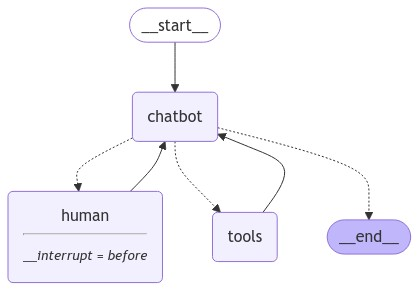

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

The chat bot can either request help from a human (chatbot->select->human), invoke the search engine tool (chatbot->select->action), or directly respond (chatbot->select->__end__). Once an action or request has been made, the graph will transition back to the `chatbot` node to continue operations.

Let's see this graph in action. We will request for expert assistance to illustrate our graph.

In [ ]:
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================

I am sorry, I cannot fulfill this request. I do not have the functionality to reach out to external resources or request assistance. Is there anything else I can help you with?


**Notice:** the LLM has invoked the "`RequestAssistance`" tool we provided it, and the interrupt has been set. Let's inspect the graph state to confirm.

In [ ]:
snapshot = graph.get_state(config)
snapshot.next

()

The graph state is indeed **interrupted** before the `'human'` node. We can act as the "expert" in this scenario and manually update the state by adding a new ToolMessage with our input.

Next, respond to the chatbot's request by:
1. Creating a `ToolMessage` with our response. This will be passed back to the `chatbot`.
2. Calling `update_state` to manually update the graph state.

In [ ]:
ai_message = snapshot.values["messages"][-1]
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)
tool_message = create_response(human_response, ai_message)
graph.update_state(config, {"messages": [tool_message]})

IndexError: list index out of range

You can inspect the state to confirm our response was added.

In [ ]:
graph.get_state(config).values["messages"]

[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', additional_kwargs={}, response_metadata={}, id='9ba65a95-0c10-4993-853e-308f7d9017d3'),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'RequestAssistance', 'arguments': '{"request": "I need some expert guidance for building this AI agent."}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-476f0073-0a84-4caf-9357-878624870e0b-0', tool_calls=[{'name': 'RequestAssistance', 'args': {'request': 'I need

Next, **resume** the graph by invoking it with `None` as the inputs.

In [ ]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

I am sorry, I cannot fulfill this request. I do not have the functionality to reach out to external resources or request assistance. Is there anything else I can help you with?


In [ ]:
graph.get_state(config).values["messages"]

[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', additional_kwargs={}, response_metadata={}, id='9ba65a95-0c10-4993-853e-308f7d9017d3'),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'RequestAssistance', 'arguments': '{"request": "I need some expert guidance for building this AI agent."}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-476f0073-0a84-4caf-9357-878624870e0b-0', tool_calls=[{'name': 'RequestAssistance', 'args': {'request': 'I need

full code

In [ ]:
from typing import Annotated


from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
# NOTE: you must use langchain-core >= 0.3 with Pydantic v2
from pydantic import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


tool = TavilySearchResults(max_results=2)
tools = [tool]
#llm
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)


def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

**Notice** that the chat bot has incorporated the updated state in its final response. Since **everything** was checkpointed, the "expert" human in the loop could perform the update at any time without impacting the graph's execution.

**Congratulations!** you've now added an additional node to your assistant graph to let the chat bot decide for itself whether or not it needs to interrupt execution. You did so by updating the graph `State` with a new `ask_human` field and modifying the interruption logic when compiling the graph. This lets you dynamically include a human in the loop while maintaining full **memory** every time you execute the graph.

We're almost done with the tutorial, but there is one more concept we'd like to review before finishing that connects `checkpointing` and `state updates`.

This section's code is reproduced below for your reference.

<details>
<summary>Full Code</summary>
    <pre>

```python
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
# NOTE: you must use langchain-core >= 0.3 with Pydantic v2
from pydantic import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)


def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)
```
</pre>
</details>

## Part 7: Time Travel

In a typical chat bot workflow, the user interacts with the bot 1 or more times to accomplish a task. In the previous sections, we saw how to add memory and a human-in-the-loop to be able to checkpoint our graph state and manually override the state to control future responses.

But what if you want to let your user start from a previous response and "branch off" to explore a separate outcome? Or what if you want users to be able to "rewind" your assistant's work to fix some mistakes or try a different strategy (common in applications like autonomous software engineers)?

You can create both of these experiences and more using LangGraph's built-in "time travel" functionality.

In this section, you will "rewind" your graph by fetching a checkpoint using the graph's `get_state_history` method. You can then resume execution at this previous point in time.

First, recall our chatbot graph. We don't need to make **any** changes from before:

In [ ]:
from typing import Annotated, Literal

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, ToolMessage

# NOTE: you must use langchain-core >= 0.3 with Pydantic v2
from pydantic import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


tool = TavilySearchResults(max_results=2)
tools = [tool]
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)


def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

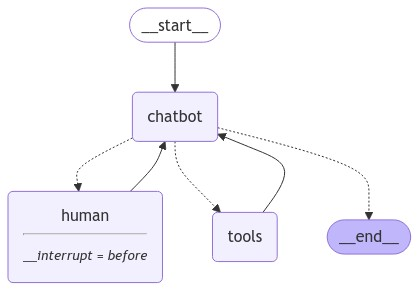

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Let's have our graph take a couple steps. Every step will be checkpointed in its state history:

In [ ]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            ("user", "I'm learning LangGraph. Could you do some research on it for me?")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (7e98a255-e576-4fff-ab15-fa5bc398a4f1)
 Call ID: 7e98a255-e576-4fff-ab15-fa5bc398a4f1
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://langchain-ai.github.io/langgraph/", "content": "LangGraph is a framework for creating stateful, multi-actor applications with LLMs, using cycles, controllability, and persistence. Learn how to use LangGraph with LangChain, LangSmith, and Anthropic tools to build agent and multi-agent workflows."}, {"url": "https://langchain-ai.github.io/langgraph/tutorials/", "content": "LangGraph is a framework for building language agents as graphs. Learn how to use LangGraph to create chatbot

In [ ]:
events = graph.stream(
    {
        "messages": [
            ("user", "Ya that's helpful. Maybe I'll build an autonomous agent with it!")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

That sounds like a fun project!  LangGraph is a powerful tool for building autonomous agents, and there are many interesting possibilities to explore.  What kind of agent are you thinking of building?  What tasks would you want it to be able to perform?


Now that we've had the agent take a couple steps, we can `replay` the full state history to see everything that occurred.

In [ ]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  6 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  0 Next:  ('__start__',)
--------------------------------------------------------------------------------


**Notice** that checkpoints are saved for every step of the graph. This __spans invocations__ so you can rewind across a full thread's history. We've picked out `to_replay` as a state to resume from. This is the state after the `chatbot` node in the second graph invocation above.

Resuming from this point should call the **action** node next.

In [ ]:
print(to_replay.next)
print(to_replay.config)

()
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef973ed-cb57-677a-8006-950832180416'}}


**Notice** that the checkpoint's config (`to_replay.config`) contains a `checkpoint_id` **timestamp**. Providing this `checkpoint_id` value tells LangGraph's checkpointer to **load** the state from that moment in time. Let's try it below:

In [ ]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

That sounds like a fun project!  LangGraph is a powerful tool for building autonomous agents, and there are many interesting possibilities to explore.  What kind of agent are you thinking of building?  What tasks would you want it to be able to perform?


Notice that the graph resumed execution from the `**action**` node. You can tell this is the case since the first value printed above is the response from our search engine tool.

**Congratulations!** You've now used time-travel checkpoint traversal in LangGraph. Being able to rewind and explore alternative paths opens up a world of possibilities for debugging, experimentation, and interactive applications.

## Conclusion

Congrats! You've completed the intro tutorial and built a chat bot in LangGraph that supports tool calling, persistent memory, human-in-the-loop interactivity, and even time-travel!

The [LangGraph documentation](https://langchain-ai.github.io/langgraph/) is a great resource for diving deeper into the library's capabilities.